In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
import gc  # Garbage Collector zur Speicherverwaltung
import sys
sys.path.append(os.path.abspath("../../"))
from eval_call import evaluate_model



df = pd.read_csv('../../data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251079 entries, 0 to 251078
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                251079 non-null  int64  
 1   brand                     251079 non-null  object 
 2   model                     251079 non-null  object 
 3   color                     250913 non-null  object 
 4   registration_date         251075 non-null  object 
 5   year                      251079 non-null  object 
 6   price_in_euro             251079 non-null  object 
 7   power_kw                  250945 non-null  object 
 8   power_ps                  250950 non-null  object 
 9   transmission_type         251079 non-null  object 
 10  fuel_type                 251079 non-null  object 
 11  fuel_consumption_l_100km  224206 non-null  object 
 12  fuel_consumption_g_km     251079 non-null  object 
 13  mileage_in_km             250927 non-null  f

In [2]:
import sys
import os

sys.path.append(os.path.abspath("../.."))
from Preprocessing.DropAll_preprocessing_pipeline import preprocessing_pipeline



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251079 entries, 0 to 251078
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                251079 non-null  int64  
 1   brand                     251079 non-null  object 
 2   model                     251079 non-null  object 
 3   color                     250913 non-null  object 
 4   registration_date         251075 non-null  object 
 5   year                      251079 non-null  object 
 6   price_in_euro             251079 non-null  object 
 7   power_kw                  250945 non-null  object 
 8   power_ps                  250950 non-null  object 
 9   transmission_type         251079 non-null  object 
 10  fuel_type                 251079 non-null  object 
 11  fuel_consumption_l_100km  224206 non-null  object 
 12  fuel_consumption_g_km     251079 non-null  object 
 13  mileage_in_km             250927 non-null  f

In [4]:
from sklearn.model_selection import train_test_split

y = df['price_in_euro']
X = df.drop(['price_in_euro'], axis=1)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessing_pipeline(X_train)
X_test = preprocessing_pipeline(X_test,"test")

In [10]:
numeric_features

['Unnamed: 0', 'mileage_in_km']

In [5]:

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  # Scaling is crucial for KNN
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



final_knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(
        n_neighbors=4,
        weights='distance',  
        algorithm='auto',
        p = 2, #Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.
        n_jobs=-1  
    ))
])


print("\nTraining KNN model ...")
final_knn_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_knn = final_knn_pipeline.predict(X_test)

# Evaluate model
evaluate_model(y_test, y_pred_knn, "KNN Regression")


# Clean up memory
gc.collect()





Training KNN model ...


ValueError: A given column is not a column of the dataframe

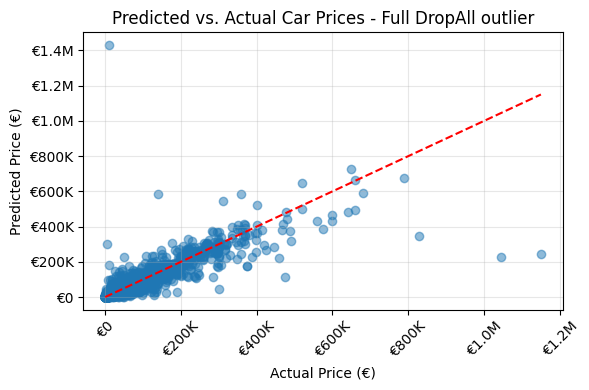

In [ ]:
from matplotlib.ticker import FuncFormatter


plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_knn, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  
plt.xlabel('Actual Price (€)')
plt.ylabel('Predicted Price (€)')
plt.title('Predicted vs. Actual Car Prices - Full DropAll outlier')


plt.grid(True, alpha=0.3)


def euros(x, pos):
    if x >= 1000000:
        return f'€{x/1000000:.1f}M'
    elif x >= 1000:
        return f'€{x/1000:.0f}K'
    else:
        return f'€{int(x)}'
    
plt.gca().xaxis.set_major_formatter(FuncFormatter(euros))
plt.gca().yaxis.set_major_formatter(FuncFormatter(euros))

plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()